# Imports

In [1]:
import pandas as pd
import numpy as np
import re
import string
import json
import os
import pickle

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

from langdetect import detect
import spacy

import nltk
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,\
classification_report, accuracy_score, precision_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,\
HashingVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from xgboost import XGBClassifier

import pendulum

_________________

**Helper Functions**

In [2]:
def confusion_matrix_plot(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    return plt.show()

def report(y_true, y_pred, class_names=['no_spoiler', 'spoiler']):
    print(classification_report(y_true, y_pred, target_names=class_names))
    confusion_matrix_plot(y_true, y_pred, class_names)

_________

Skip to section 2.3 to load the large dataframe after initial EDA and processing. Then all cells in the remainder of section 2 as well as section 3 are able the be executed.

To save time we can also skip to section 4 and load the review dataframe (with original and lemmatized reviews) and the summaries dataframe for modeling.

# EDA

## Movie Details

In [3]:
movie_details = pd.read_json('./data/IMDB_movie_details.json', lines=True)
display(movie_details.info())
movie_details

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1572 entries, 0 to 1571
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       1572 non-null   object 
 1   plot_summary   1572 non-null   object 
 2   duration       1572 non-null   object 
 3   genre          1572 non-null   object 
 4   rating         1572 non-null   float64
 5   release_date   1572 non-null   object 
 6   plot_synopsis  1572 non-null   object 
dtypes: float64(1), object(6)
memory usage: 86.1+ KB


None

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in..."
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",1h 45min,[Comedy],6.6,2013-11-01,Four boys around the age of 10 are friends in ...
2,tt0243655,"The setting is Camp Firewood, the year 1981. I...",1h 37min,"[Comedy, Romance]",6.7,2002-04-11,
3,tt0040897,"Fred C. Dobbs and Bob Curtin, both down on the...",2h 6min,"[Adventure, Drama, Western]",8.3,1948-01-24,Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...
4,tt0126886,Tracy Flick is running unopposed for this year...,1h 43min,"[Comedy, Drama, Romance]",7.3,1999-05-07,Jim McAllister (Matthew Broderick) is a much-a...
...,...,...,...,...,...,...,...
1567,tt0289879,Evan Treborn grows up in a small town with his...,1h 53min,"[Sci-Fi, Thriller]",7.7,2004-01-23,"In the year 1998, Evan Treborn (Ashton Kutcher..."
1568,tt1723811,Brandon is a 30-something man living in New Yo...,1h 41min,[Drama],7.2,2012-01-13,"Brandon (Michael Fassbender) is a successful, ..."
1569,tt5013056,Evacuation of Allied soldiers from the British...,1h 46min,"[Action, Drama, History]",8.1,2017-07-21,The film alternates between three different pe...
1570,tt0104014/,"For a while now, beautiful 24-year-old Diana B...",1h 33min,"[Comedy, Drama]",5.3,1992-02-21,


Convert 'release_date' to a datetime object

In [4]:
movie_details['release_date'] = pd.to_datetime(movie_details.release_date)

Convert duration into a minute count (integer)

In [5]:
hour = re.compile('(\d+)h')
minute = re.compile('(\d+)min')

def duration_convert(df):
    # set intial duration to 0
    duration = 0
    # find number of hours and minutes
    hour_found = hour.findall(df.duration)
    minute_found = minute.findall(df.duration)
    # if hours, multiply value by 60 and add to duration
    if hour_found:
        duration += 60 * int(hour_found[0])
    # if minutes, add to duration
    if minute_found:
        duration += int(minute_found[0])
    # return total number of minutes
    return duration

movie_details['duration'] = movie_details.apply(duration_convert, axis=1)

Confirm that genre contains lists for possible future genre analysis

In [6]:
for i in list(range(len(movie_details))):
    count = 0
    if str(type(movie_details.iloc[i].genre)) != "<class 'list'>":
        count += 1
        print(type(movie_details.iloc[i].genre))
print(f"There are {count} entries for genre that are not a list")

There are 0 entries for genre that are not a list


There are some movie_ids that have a trailing forward slash, we need to fix that to merge the data

In [14]:
def fix_movie_id(df):
    if df.movie_id[-1] == '/':
        return  df.movie_id[:-1]
    else:
        return df.movie_id

movie_details['movie_id'] = movie_details.apply(fix_movie_id, axis=1)

_____________
Check on how many empty plot summary/synopsis there are

In [15]:
empty_summary = len(movie_details[movie_details.plot_summary == ''])
empty_synopsis = len(movie_details[movie_details.plot_synopsis == ''])
print(f"There are {empty_summary} entries with an empty summary.\nThere are {empty_synopsis} entries with an empty synopsis.")

There are 0 entries with an empty summary.
There are 233 entries with an empty synopsis.


In [16]:
first_summary_len = len(movie_details.iloc[0].plot_summary)
first_synopsis_len = len(movie_details.iloc[0].plot_synopsis)
print(f"The first entry summary length is: {first_summary_len}\nThe first entry synopsis length is: {first_synopsis_len}")

The first entry summary length is: 1034
The first entry synopsis length is: 8605


In [20]:
no_synopsis_ids = list(movie_details[movie_details.plot_synopsis == '']['movie_id'])

with open('no_synopsis_ids.pkl', 'wb') as f:
    pickle.dump(no_synopsis_ids, f)

# load the saved list of indicies
with open('no_synopsis_ids.pkl', 'rb') as f:
    no_synopsis_ids = pickle.load(f)

The first entry's summary and synopsis reveals that the former is shorter than the latter, which is the field containing some missing values. Checking the whole dataframe to see if that relationship is always the case.

In [19]:
count = 0

for i in list(range(len(movie_details))):
    if movie_details.iloc[i].plot_synopsis != '':
        summary_len = len(movie_details.iloc[i].plot_summary)
        synopsis_len = len(movie_details.iloc[i].plot_synopsis)
        if summary_len > synopsis_len:
            count += 1
    
print(f"There are {count} entries with a synopsis where the summary length is greater than the synopsis length.")

There are 23 entries with a synopsis where the summary length is greater than the synopsis length.


It would be best to use the film synopsis as it is longer and contains more detail about the film. But we are missing 233 synopses from the data. We have saved the film_ids for these films with missing synopsis. With that many missing, we will use the film summary instead of synopsis.

### Entity extraction of film summary

In [ ]:
# def summary_entities(row):
#     # get the film summary
#     summary = row.plot_summary
#     # generate new features for character and word count of the summary
#     row['summary_char_count'] = len(summary)
#     row['summary_word_count'] = len(summary.split(' '))
#     # get the entities with spacy
#     doc = nlp(summary)
#     # initialize list of entities and their counts
#     ent_list = []
#     ent_count = []
#     # append each entity to the list of entities
#     for ent in doc.ents:
#         ent_list.append(ent.text)
#     # generate the set of unique entities
#     ent_set = set(ent_list)
#     # append a tuple to ent_count with each found entity and its count
#     for ent in ent_set:
#         ent_count.append((ent, ent_list.count(ent)))
#     # set number of unique entities and initialize the total count to 0
#     unique_ents = len(ent_count)
#     unique_ent_count = 0
#     # for each tuple, add the count from the entity frequency to the total count
#     for x in ent_count:
#         unique_ent_count += x[1]
#     # get the average count for an entity
#     if unique_ents != 0:
#         avg_count = round(unique_ent_count / unique_ents, 2)
#     else:
#         avg_count = 0
#     # generate new features for the total entity count, unique count, and avg frequency
#     row['summary_entity_count'] = len(ent_list)
#     row['summary_unique_entities'] = unique_ents
#     row['summary_avg_entity_freq'] = avg_count
#     # return the row
#     return row

# movie_details = movie_details.apply(summary_entities, axis=1)

### Tokenize film summary

In [ ]:
# summary_stopwords = stopwords.words('english')
# pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
# tokenizer = RegexpTokenizer(pattern)

# def summary_tokenize(row):
#     # get the film summary
#     summary = row.plot_summary
#     # tokenize
#     summary_tokens = tokenizer.tokenize(summary)
#     summary_tokens = [token.lower() for token in summary_tokens]
#     summary_tokens = [token for token in summary_tokens if token not in summary_stopwords]
#     # set new feature to token list
#     row['summary_tokens'] = summary_tokens
#     row['summary_token_count'] = len(summary_tokens)
#     return row

# movie_details = movie_details.apply(summary_tokenize, axis=1)

## Movie Reviews

In [11]:
movie_reviews = pd.read_json('./data/IMDB_reviews.json', lines=True)
display(movie_reviews.info())
movie_reviews

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573913 entries, 0 to 573912
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   review_date     573913 non-null  object
 1   movie_id        573913 non-null  object
 2   user_id         573913 non-null  object
 3   is_spoiler      573913 non-null  bool  
 4   review_text     573913 non-null  object
 5   rating          573913 non-null  int64 
 6   review_summary  573913 non-null  object
dtypes: bool(1), int64(1), object(5)
memory usage: 26.8+ MB


None

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted"
...,...,...,...,...,...,...,...
573908,8 August 1999,tt0139239,ur0100166,False,"Go is wise, fast and pure entertainment. Assem...",10,The best teen movie of the nineties
573909,31 July 1999,tt0139239,ur0021767,False,"Well, what shall I say. this one´s fun at any ...",9,Go - see the movie
573910,20 July 1999,tt0139239,ur0392750,False,"Go is the best movie I have ever seen, and I'v...",10,It's the best movie I've ever seen
573911,11 June 1999,tt0139239,ur0349105,False,Call this 1999 teenage version of Pulp Fiction...,3,Haven't we seen this before?


In [12]:
unique_movies_in_reviews = movie_reviews.movie_id.nunique()
print(f"There are {len(movie_details)} entries in movie_details and {unique_movies_in_reviews} unique movie_id's in movie_reviews")

There are 1572 entries in movie_details and 1572 unique movie_id's in movie_reviews


Converting the review_date to datetime

In [13]:
movie_reviews['review_date'] = pd.to_datetime(movie_reviews.review_date)

In [14]:
movie_reviews.describe(datetime_is_numeric=True)

,review_date,rating
count,573913,573913.000000
mean,2009-07-20 04:42:25.548193280,6.954254
min,1998-07-28 00:00:00,1.000000
25%,2005-06-18 00:00:00,5.000000
50%,2009-07-25 00:00:00,8.000000
75%,2014-05-15 00:00:00,10.000000
max,2018-01-07 00:00:00,10.000000
std,NaN,2.956295


### Entity extraction of reviews

This processing takes just under 8 hours.

In [ ]:
# nlp = spacy.load('en_core_web_sm')

# def entity_info(row):
#     # get the review summary
#     review = row.review_text
#     # generate new features for character and word count of the summary
#     row['char_count'] = len(review)
#     row['word_count'] = len(review.split(' '))
#     # get the entities with spacy
#     doc = nlp(review)
#     # initialize list of entities and their counts
#     ent_list = []
#     ent_count = []
#     # append each entity to the list of entities
#     for ent in doc.ents:
#         ent_list.append(ent.text)
#     # generate the set of unique entities
#     ent_set = set(ent_list)
#     # append a tuple to ent_count with each found entity and its count
#     for ent in ent_set:
#         ent_count.append((ent, ent_list.count(ent)))
#     # set number of unique entities and initialize the total count to 0
#     unique_ents = len(ent_count)
#     unique_ent_count = 0
#     # for each tuple, add the count from the entity frequency to the total count
#     for x in ent_count:
#         unique_ent_count += x[1]
#     # get the average count for an entity
#     if unique_ents != 0:
#         avg_count = round(unique_ent_count / unique_ents, 2)
#     else:
#         avg_count = 0
#     # generate new features for the total entity count, unique count, and avg frequency
#     row['entity_count'] = len(ent_list)
#     row['unique_entities'] = unique_ents
#     row['avg_entity_freq'] = avg_count
#     # return the row
#     return row

# movie_reviews = movie_reviews.apply(entity_info, axis=1)

### Tokenize reviews

In [ ]:
# summary_stopwords = stopwords.words('english')
# pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
# tokenizer = RegexpTokenizer(pattern)

# def review_tokenize(row):
#     # get the film review
#     review = row.review_text
#     # tokenize
#     review_tokens = tokenizer.tokenize(review)
#     review_tokens = [token.lower() for token in review_tokens]
#     review_tokens = [token for token in review_tokens if token not in summary_stopwords]
#     # set new feature to token list
#     row['review_tokens'] = review_tokens
#     row['review_token_count'] = len(review_tokens)
#     return row

# movie_reviews = movie_reviews.apply(review_tokenize, axis=1)

## Merge/Load all data

In [ ]:
# merged_df = pd.merge(movie_details, movie_reviews, on='movie_id', how="right")

# corrected_columns = ['movie_id', 'plot_summary', 'duration', 'genre', 'film_rating',
#                      'release_date', 'plot_synopsis', 'summary_char_count',
#                      'summary_word_count', 'summary_entity_count', 'summary_unique_entities',
#                      'summary_avg_entity_freq', 'summary_tokens', 'summary_token_count',
#                      'review_date', 'user_id', 'is_spoiler', 'review_text', 'reviewer_rating',
#                      'review_summary', 'review_char_count', 'review_word_count', 'review_entity_count',
#                      'review_unique_entities', 'review_avg_entity_freq', 'review_tokens',
#                      'review_token_count']

# merged_df.columns = corrected_columns

# merged_df.to_parquet('./data/full_dataframe.parquet')

This cell reads in the full dataframe from the saved parquet file. The file is large, 573,913 entries with 27 features, takes up about 1.9 GB of space. The load takes about a minute

In [3]:
merged_df = pd.read_parquet('./data/full_dataframe.parquet')

In [4]:
merged_df['is_spoiler'] = merged_df.is_spoiler.astype(int)

### Exploring review (word count, language)

In [5]:
merged_df.review_word_count.describe()

count    573913.000000
mean        259.399052
std         195.438284
min           1.000000
25%         131.000000
50%         189.000000
75%         322.000000
max        2673.000000
Name: review_word_count, dtype: float64

In [6]:
outlier_wc = round(merged_df.review_word_count.mean() + (3 * merged_df.review_word_count.std()),)
print("Upper outlier boundary for word count:", outlier_wc)
print("Lower 2.5% reviews word count:", merged_df.review_word_count.quantile(0.025))
print("Upper 2.5% reviews word count:", merged_df.review_word_count.quantile(0.975))

Upper outlier boundary for word count: 846
Lower 2.5% reviews word count: 54.0
Upper 2.5% reviews word count: 848.0


We saw that our minimum review word count is 1, and our maximum is 2673, but our average is just about 260 words. Defining outliers as 3x the std from the mean, we would not have any lower bound outliers, and our upper bound outliers would be 846 words. Our bottom 2.5% of reviews contains fewer words than 54 and our upper 2.5% contain more words than 848, which is close to the threshold we calculated for outliers.

54 words is still quite a few and our model may see value in reviews with that many words, but there may not be value in reviews that are really short.

Lets explore restricting reviews by length by looking at the counts for reviews with low word counts. We can modify the max_count value in this next cell to get the frequency by word count, total, and the indicies of all the reviews in question for easy removal

In [7]:
total = 0
min_count = 1
max_count = 54
review_indices = []

for x in range(min_count,max_count+1):
    df = merged_df[merged_df.review_word_count == x]
    indices = list(df.index)
    review_indices.extend(indices)
    count = len(df)
    total += count
#     print(f"Reviews with {x} words: {count}")
print(f"There are {total} reviews containing {max_count} or fewer words.")

There are 14512 reviews containing 54 or fewer words.


In [8]:
merged_df.iloc[review_indices].is_spoiler.value_counts()

0    14211
1      301
Name: is_spoiler, dtype: int64

In [9]:
total = 0
min_count = 846
max_count = 2673
review_indices = []

for x in range(min_count,max_count+1):
    df = merged_df[merged_df.review_word_count == x]
    indices = list(df.index)
    review_indices.extend(indices)
    count = len(df)
    total += count
#     if count > 0:
#         print(f"Reviews with {x} words: {count}")
print(f"There are {total} reviews containing {min_count} or more words.")

There are 14518 reviews containing 846 or more words.


In [10]:
merged_df.iloc[review_indices].is_spoiler.value_counts()

1    7437
0    7081
Name: is_spoiler, dtype: int64

There are 14,512 reviews under 54 words and most of them (97.9%) are not spoilers. There are 14,518 reviews over 846 words, and unfortunately they contain a small majority of spoilers, much more by percent than our whole dataset. 

We also discovered through investigation that we have some not english text in reviews, one example in review at iloc 1533. We will engineer a new feature using langdetect to flag any reviews that are not in english.

In [11]:
merged_df.iloc[1533].review_text

'Izledigim filmeler arasinda pek hayli yer kaplamaktadir'

In [12]:
detect(merged_df.iloc[1533].review_text)

'tr'

In [13]:
# def non_english_review(df):
#     review = df.review_text
#     if detect(review) != 'en':
#         return 1
#     else:
#         return 0

# this takes about an hour and a half
# merged_df['non_english_review'] = merged_df.apply(non_english_review, axis=1)

# pulling the index values of those entries with non-english reviews
# non_english_reviews = list(merged_df[merged_df.non_english_review == 1].index)
# going to save this to a pickle file to load later for removing these reviews instead of processing
# each time
# with open('non_english_reviews.pkl', 'wb') as f:
#     pickle.dump(non_english_reviews, f)

# load the saved list of indicies
with open('non_english_reviews.pkl', 'rb') as f:
    non_english_reviews = pickle.load(f)

# look at how many non-english reviews we have
print(f"Number of non-english reviews: {len(non_english_reviews)}")

Number of non-english reviews: 53


With so few non-english reviews, we will remove them from consideration in modeling.

Something we're not sure about is restricting our reviews based on word count, specifically very low or very high counts. Our average review count was about 260, so we are concerned about picking up on what is spoiler-y in those 'outlier' word count reviews.

In [14]:
merged_df.drop(non_english_reviews, inplace=True)
merged_df.reset_index(drop=True, inplace=True)

## Explore spoilers vs non-spoilers

In [132]:
merged_df[merged_df.is_spoiler == 1].describe()

,duration,film_rating,summary_char_count,summary_word_count,summary_entity_count,summary_unique_entities,summary_avg_entity_freq,summary_token_count,is_spoiler,reviewer_rating,review_char_count,review_word_count,review_entity_count,review_unique_entities,review_avg_entity_freq,review_token_count,non_english_review
count,150909.000000,150909.000000,150909.000000,150909.000000,150909.000000,150909.000000,150909.000000,150909.000000,150909.0,150909.000000,150909.000000,150909.000000,150909.000000,150909.000000,150909.000000,150909.000000,150909.0
mean,121.128488,7.280335,624.412116,117.460476,9.187166,7.519770,1.195448,59.631129,1.0,6.517444,1887.806353,334.917997,17.256658,13.035869,1.256000,173.768132,0.0
std,24.940509,0.948578,237.507669,41.978237,5.533896,4.162631,0.294973,22.896131,0.0,3.015920,1283.836091,223.268510,15.865774,10.606327,0.369353,118.606237,0.0
min,42.000000,2.400000,95.000000,15.000000,0.000000,0.000000,0.000000,8.000000,1.0,1.000000,50.000000,8.000000,0.000000,0.000000,0.000000,6.000000,0.0
25%,105.000000,6.700000,427.000000,82.000000,5.000000,4.000000,1.000000,41.000000,1.0,4.000000,920.000000,166.000000,6.000000,6.000000,1.000000,85.000000,0.0
50%,119.000000,7.400000,593.000000,114.000000,8.000000,7.000000,1.120000,57.000000,1.0,7.000000,1459.000000,261.000000,12.000000,10.000000,1.170000,135.000000,0.0
75%,136.000000,8.000000,803.000000,147.000000,12.000000,10.000000,1.310000,77.000000,1.0,9.000000,2456.000000,435.000000,23.000000,17.000000,1.380000,226.000000,0.0
max,321.000000,9.500000,1077.000000,212.000000,31.000000,25.000000,3.330000,144.000000,1.0,10.000000,14302.000000,2565.000000,176.000000,129.000000,22.000000,1295.000000,0.0


In [133]:
merged_df[merged_df.is_spoiler == 0].describe()

,duration,film_rating,summary_char_count,summary_word_count,summary_entity_count,summary_unique_entities,summary_avg_entity_freq,summary_token_count,is_spoiler,reviewer_rating,review_char_count,review_word_count,review_entity_count,review_unique_entities,review_avg_entity_freq,review_token_count,non_english_review
count,422951.000000,422951.000000,422951.000000,422951.000000,422951.000000,422951.000000,422951.000000,422951.000000,422951.0,422951.000000,422951.000000,422951.000000,422951.000000,422951.000000,422951.000000,422951.000000,422951.0
mean,120.942258,7.298362,627.099151,118.291786,9.237148,7.556064,1.196654,60.078550,0.0,7.109942,1308.228097,232.475417,11.541337,9.341266,1.148739,120.600954,0.0
std,25.483269,0.963061,238.361767,42.148804,5.541603,4.174879,0.296576,22.920888,0.0,2.918918,1021.058027,176.857874,12.086183,8.651151,0.351401,94.618036,0.0
min,42.000000,2.400000,95.000000,15.000000,0.000000,0.000000,0.000000,8.000000,0.0,1.000000,18.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.0
25%,104.000000,6.700000,431.000000,83.000000,5.000000,4.000000,1.000000,41.000000,0.0,5.000000,682.000000,124.000000,4.000000,4.000000,1.000000,63.000000,0.0
50%,118.000000,7.400000,593.000000,114.000000,8.000000,7.000000,1.120000,58.000000,0.0,8.000000,947.000000,171.000000,8.000000,7.000000,1.070000,87.000000,0.0
75%,135.000000,8.000000,800.000000,148.000000,12.000000,10.000000,1.310000,78.000000,0.0,10.000000,1575.000000,280.000000,14.000000,12.000000,1.250000,145.000000,0.0
max,321.000000,9.500000,1077.000000,212.000000,31.000000,25.000000,3.330000,144.000000,0.0,10.000000,14963.000000,2673.000000,213.000000,179.000000,27.000000,1333.000000,0.0


Initial observations from the describe calls on reviews marked as spoiler versus ones that are not:
- The reviewer rating is about half a point lower on average for reviews marked as spoilers
- The review word count of a spoiler review is longer on average by about 36% (232 -> 335), but does have a more variation
- Rougly the same can be said about the entity counts (raw and unique)

It looks like there is nothing glaringly obvious about the difference between spoiler and non-spoiler reviews in terms of entities or raw word counts

### frequency

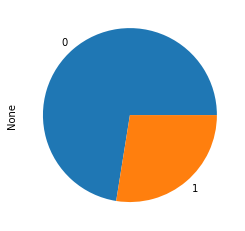

In [44]:
merged_df.groupby('is_spoiler').size().plot(kind='pie');

### by genre - data removal at end of section

Pull just the genre feature along with the target 'is_spoiler' so that each film is represented in each genre it's a part of.

In [50]:
genres = merged_df[['genre', 'is_spoiler']].explode('genre').copy()

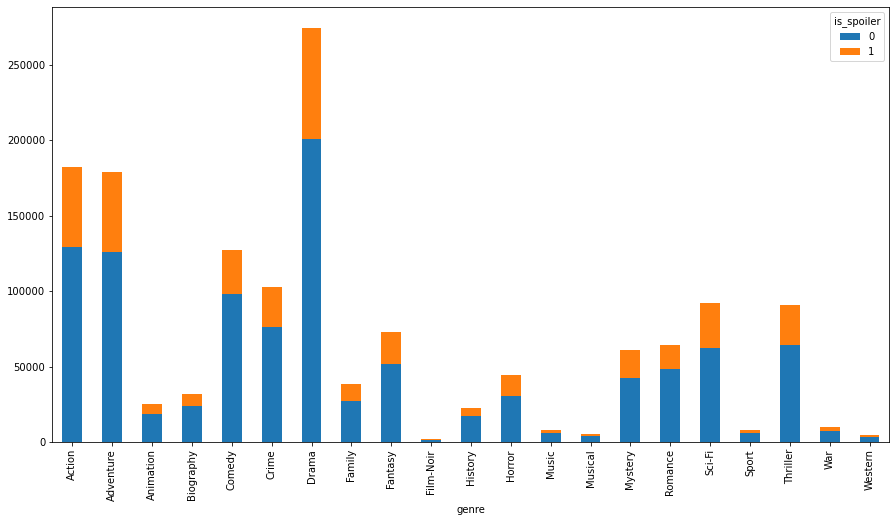

In [51]:
genres.groupby(['genre', 'is_spoiler']).size().unstack().plot(kind='bar', stacked=True, figsize=(15,8));

The smaller 6 categories are: Film-Noir, Music, Musical, Sport, War, and Western. It's important to note that most of the films reviews are classified with multiple genres. We may consider dropping these films as they don't represent a majority of film reviews. It may be more difficult for the model to correctly identify spoilers from films in these generes, but it may also improve modeling in the majority of reviews.

In [134]:
genres_to_drop = ['Film-Noir', 'Music', 'Musical', 'Sport', 'War', 'Western']
genre_indicies = []

for x in range(len(merged_df)):
    
    genres = merged_df.iloc[x].genre
    
    if len(genres) == 1:
        if any(x in genres_to_drop for x in genres):
            genre_indicies.append(x)
    
# def review_to_drop(df):
#     genres = df.genre
#     if len(genres) == 1:
#         if any(x in genres_to_drop for x in genres):
#             genre_indicies.append(df.index)
#     else:
#         return 0

# merged_df['review_to_drop'] = merged_df.apply(review_to_drop, axis=1)

In [140]:
print(f"There are {len(genre_indicies)} film reviews that review a film that is only one genre of our listed genres")
print("----------------------------------------------------------------")
print("This is the breakdown of our target value among these reviews:")
print(merged_df.iloc[genre_indicies].is_spoiler.value_counts())

There are 1353 film reviews that review a film that is only one genre of our listed genres
----------------------------------------------------------------
This is the breakdown of our target value among these reviews:
0    1066
1     287
Name: is_spoiler, dtype: int64


In [23]:
genre_breakdown = genres.groupby(['genre', 'is_spoiler']).size().unstack()
# genre_breakdown['percent_true'] = genre_breakdown.apply(lambda x: x..True / (x.True + x.False))

In [24]:
genre_breakdown

is_spoiler,0,1
genre,,
Action,136820,53897
Adventure,133559,53734
Animation,19763,6834
Biography,25115,7992
Comedy,106658,29315
Crime,82659,27011
Drama,215137,74230
Family,28857,10702
Fantasy,55404,21694


### by user ID

In [25]:
user_ids = merged_df[['user_id', 'is_spoiler']].copy()
user_ids.user_id.value_counts()

ur2898520     1303
ur4248714     1021
ur0453068      806
ur60028700     770
ur20552756     755
              ... 
ur13992719       1
ur44287431       1
ur23173336       1
ur33891945       1
ur0156431        1
Name: user_id, Length: 263407, dtype: int64

In [26]:
user_ids.user_id.value_counts().values.sum() / len(user_ids.user_id.value_counts())

2.1788069413493187

There are 263,407 unique users represented in the data. We can see that the vast majority do not comment more than once. The average number of comments is 2.17. Lets look at our top 20 commenters.

In [28]:
user_id_split_df = user_ids.groupby(['user_id', 'is_spoiler']).size().unstack().sort_values(by=0, ascending=False)
# user_id_split_df.
user_id_split_df[:20]

is_spoiler,0,1
user_id,,
ur2898520,1283.0,20.0
ur20552756,742.0,13.0
ur0453068,735.0,71.0
ur1234929,670.0,10.0
ur4888011,658.0,43.0
ur2488512,616.0,65.0
ur17646017,587.0,41.0
ur23055365,561.0,16.0
ur4445210,539.0,45.0


There are some null values where the user only has comments of one target class or the other. We will set them to zero

In [29]:
user_id_split_df.fillna(0.0, inplace=True)

In [30]:
testing = user_id_split_df.reset_index()
testing.columns = ['user_id', 'non_spoiler', 'spoiler']
testing

,user_id,non_spoiler,spoiler
0,ur2898520,1283.0,20.0
1,ur20552756,742.0,13.0
2,ur0453068,735.0,71.0
3,ur1234929,670.0,10.0
4,ur4888011,658.0,43.0
...,...,...,...
263402,ur9990913,0.0,1.0
263403,ur9992465,0.0,1.0
263404,ur9993627,0.0,1.0
263405,ur9995532,0.0,1.0


In [31]:
def total_and_percent(row):
    
    total = row.non_spoiler + row.spoiler
    row['total'] = total
    
    if row.non_spoiler == 0.0:
        row['percent_spoiled'] = 1.0
        
    else:
        row['percent_spoiled'] = row.spoiler / total
        
    return row

In [32]:
testing = testing.apply(total_and_percent, axis=1)

In [33]:
testing[testing.total > 5.0].sort_values(by='percent_spoiled', ascending=False)[:20]

,user_id,non_spoiler,spoiler,total,percent_spoiled
263335,ur9938570,0.0,112.0,112.0,1.0
225272,ur24052844,0.0,13.0,13.0,1.0
225820,ur24421425,0.0,7.0,7.0,1.0
225804,ur24409764,0.0,10.0,10.0,1.0
225796,ur24403695,0.0,14.0,14.0,1.0
225711,ur24340247,0.0,82.0,82.0,1.0
225652,ur24310671,0.0,6.0,6.0,1.0
225619,ur24292397,0.0,9.0,9.0,1.0
225386,ur24139670,0.0,6.0,6.0,1.0
225279,ur24062644,0.0,54.0,54.0,1.0


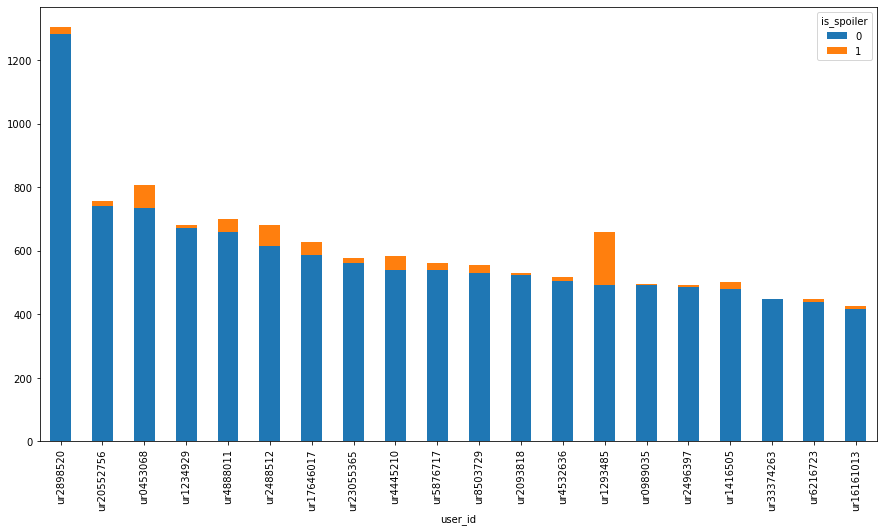

In [34]:
# top 20 reviewers by total count, separated into spoiler/non
user_ids.groupby(['user_id', 'is_spoiler']).size().unstack().sort_values(by=0, ascending=False)[:20].plot(kind='bar', stacked=True, figsize=(15,8));

In [35]:
test_df = merged_df.groupby('is_spoiler').apply(lambda x: x.sample(frac=0.01))
test_df.reset_index(drop=True, inplace=True)

# Baseline Model

Our baseline model is going to say that any review that contains the word "spoiler" is, in-fact, a spoiler.

In [141]:
# make a baseline dataframe with just the target and the review_text
baseline_df = merged_df[['is_spoiler', 'review_text']].copy()

# create a new boolean value for reviews that contain the word 'spoiler'
baseline_df['contains_spoiler'] = baseline_df.review_text.str.contains('spoiler')
baseline_df['contains_spoiler'] = baseline_df.contains_spoiler.astype(int)

              precision    recall  f1-score   support

  no_spoiler       0.75      0.99      0.85    422951
     spoiler       0.60      0.06      0.10    150909

    accuracy                           0.74    573860
   macro avg       0.67      0.52      0.48    573860
weighted avg       0.71      0.74      0.65    573860



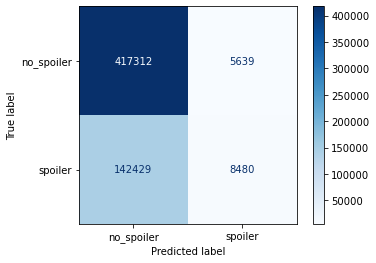

In [142]:
report(baseline_df.is_spoiler, baseline_df.contains_spoiler)

Baseline accuracy is about 74%, which sounds great, but the recall on spoilers is very low. The amount of false negatives is staggeringly high. Interestingly, there are lots of films whose review contains the word 'spoiler' but are not marked as such. That could something as simple as a user stating 'No spoilers follow', but it does seem curious to have that many film reviews that aren't spoilers.

## Non-language feature modeling

We thought it would be interesting to model using the non-language features of our data. Features which don't pertain to the summary or review text include:
- film duration
- genre
- rating
- release date
- review date
- is_spoiler (target)

In [38]:
non_lang_features = ['duration', 'genre', 'film_rating', 'release_date', 'review_date',
                     'is_spoiler']
non_language_df = merged_df[non_lang_features].copy()

Engineer a new feature: age of film at review

In [39]:
def film_age(df):
    age = df.review_date - df.release_date
    return age.days

non_language_df['days_since_release'] = non_language_df.apply(film_age, axis=1)
non_language_df.drop(['release_date', 'review_date'], axis=1, inplace=True)

Explode the genres. [Inspiration](https://stackoverflow.com/questions/45312377/how-to-one-hot-encode-from-a-pandas-column-containing-a-list)

In [40]:
s = non_language_df['genre'].explode()
non_language_df = non_language_df[['duration', 'film_rating', 'is_spoiler',
                                   'days_since_release']].join(pd.crosstab(s.index, s))

### SGD Classifier

We are going to try using a SGD classifer to see how well it performs

In [41]:
# set X and y
X = non_language_df.drop('is_spoiler', axis=1)
y = non_language_df['is_spoiler']

# perform train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# scale the predictors
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

Performing a grid search for optimized parameters. This runs in about 18 minutes, so it's commented out and the best parameters are listed below

In [43]:
params = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber", "perceptron"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "elasticnet", "none"],
}

clf = SGDClassifier(max_iter=1000)
grid = GridSearchCV(clf, param_grid=params, cv=10, n_jobs=-1)

# grid.fit(X_train, y_train)

# print(grid.best_params_)

Best params were:
- alpha: 0.0001
- loss: 'hinge'
- penalty: 'l2'

In [44]:
sgd_model = SGDClassifier(alpha=0.0001, loss='hinge', penalty='l2')
sgd_model.fit(X_train_s, y_train)

SGDClassifier()

In [45]:
y_pred = sgd_model.predict(X_test_s)

              precision    recall  f1-score   support

  no_spoiler       0.74      1.00      0.85     84508
     spoiler       0.00      0.00      0.00     30275

    accuracy                           0.74    114783
   macro avg       0.37      0.50      0.42    114783
weighted avg       0.54      0.74      0.62    114783



C:\Users\brtra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\brtra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\brtra\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


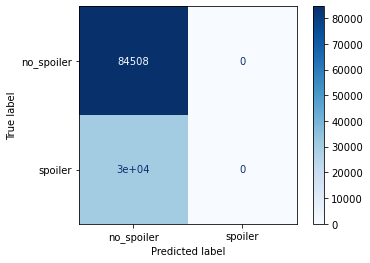

In [46]:
report(y_test, y_pred)

Modeling on the film review metadata we have does not look promising.

# Data Preparation

Pulling the summaries into one dataframe and the reviews into another, retaining the movie_id for eventual combination.

The lemmatizing of the reviews done in 5.1 takes about an hour and a half, so to save time we processed it and save the files as parquet files. All we need to do is import the files.
**Since we performed the lemmatizing, we have discovered some non-english reviews. We have the indicies to remove them generated in 2.3.1, stored as non_english_reviews**

In [143]:
# # these lines are the original creation of the dataframes
# summary_df = merged_df[['movie_id', 'plot_summary']].copy()
# summary_df.drop_duplicates(inplace=True)
# summary_df.reset_index(drop=True, inplace=True)
# review_df = merged_df[['movie_id', 'review_text', 'is_spoiler']].copy()

# deleting the merged_df
# del merged_df

In [3]:
# loading the reviews, contains both original and lemmed field
review_df = pd.read_parquet('./data/reviews_lemmed.parquet')
# loading the summaries, contains both original and lemmed field
summary_df = pd.read_parquet('./data/plot_summary_lemmed.parquet')

After original lemmatization of the reviews, we realized that there were some non-english reviews that existed in our data. In 2.3.1 we identified the indicies of the non-english reviews and then saved that list in a pickle file. Here, we load that list and use it to remove those few non-english reviews rows from the dataframe.  

In [4]:
with open('non_english_reviews.pkl', 'rb') as f:
    non_english_reviews = pickle.load(f)

# dropping non english reviews
review_df.drop(non_english_reviews, axis=0, inplace=True)
review_df.reset_index(drop=True, inplace=True)

In [17]:
# this is to output our data to a csv for uploading to cloud modeling services
# review_df[['review_text_lemmed', 'is_spoiler']].to_csv('./data/reviews.csv')

_________
Setting up a testing Dataframe to ensure things work before applying to all data. It's 1/100th of the size so we can test quickly and extrapolate processing times for the entire dataframe

In [18]:
# test_df = review_df.groupby('is_spoiler').apply(lambda x: x.sample(frac=0.01))
# test_df.reset_index(drop=True, inplace=True)
# test_df

## lemmatization (already processed)

This was performed once and then the dataframe was saved. It's left here in case we need to modify and reprocess the lemmatization.

In [13]:
sw = stopwords.words('english')
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
tokenizer = RegexpTokenizer(r"([a-zA-Z]+(?:[’'][a-z]+)?)")
lemmatizer = nltk.stem.WordNetLemmatizer()

# helper function to correctly format the part of speech
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
# helper function to clean and lemmatize the review
def lem_review(df):
    # get the doc text
    doc = df.review_text
    # tokenize the doc, lowercase all words and remove stopwords
    doc = tokenizer.tokenize(doc)
    doc = [token.lower() for token in doc]
    doc = [token for token in doc if token not in sw]
    # tag part of speach and convert format of tagging
    doc_tagged = pos_tag(doc)
    doc_tagged = [(token[0], get_wordnet_pos(token[1])) for token in doc_tagged]
    # lemmatize the doc
    doc_lemmed = [lemmatizer.lemmatize(token[0], token[1]) for token in doc_tagged]
    # join the lemmas together as a string
    doc_cleaned = ' '.join(doc_lemmed)
    # return the cleaned doc
    return doc_cleaned

# helper function to clean and lemmatize the summary
def lem_summary(df):
    # get the doc text
    doc = df.plot_summary
    # tokenize the doc, lowercase all words and remove stopwords
    doc = tokenizer.tokenize(doc)
    doc = [token.lower() for token in doc]
    doc = [token for token in doc if token not in sw]
    # tag part of speach and convert format of tagging
    doc_tagged = pos_tag(doc)
    doc_tagged = [(token[0], get_wordnet_pos(token[1])) for token in doc_tagged]
    # lemmatize the doc
    doc_lemmed = [lemmatizer.lemmatize(token[0], token[1]) for token in doc_tagged]
    # join the lemmas together as a string
    doc_cleaned = ' '.join(doc_lemmed)
    # return the cleaned doc
    return doc_cleaned

In [14]:
# this takes about an hour and a half
# review_df['review_text_lemmed'] = review_df.apply(lem_review, axis=1)

# this takes about 9 seconds
# summary_df['plot_summary_lemmed'] = summary_df.apply(lem_summary, axis=1)

Because it took so long to lemmatize the reviews, we are going to save both of these dataframes as parquet files to make modeling easier on ourselves.

In [16]:
# because it took so long, we are going to save it to a parquet file
# review_df.to_parquet('./data/reviews_lemmed.parquet')

# we are also saving the summary dataframe as well to save time
# summary_df.to_parquet('./data/plot_summary_lemmed.parquet')

## set train/val/test

In [5]:
# set X to the review text lemmed, y to target
X = review_df.review_text_lemmed
y = review_df.is_spoiler

# We want 10% of our data for test and 10% for validation, generate our holdout number
holdout = round(len(X) * 0.1)

In [6]:
# do first train/test split for train/val set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, random_state=42, test_size=holdout)

# perform 2nd train/test split (on train/val) for train and val sets
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, random_state=42, test_size=holdout)

# delete the X, y and trainval variables (no longer needed)
del X, y, X_trainval, y_trainval

# confirm shapes
print(f"X_train / y_train shapes: {X_train.shape}, {y_train.shape}")
print(f"X_val / y_val shapes: {X_val.shape}, {y_val.shape}")
print(f"X_test / y_test shapes: {X_test.shape}, {y_test.shape}")

X_train / y_train shapes: (459088,), (459088,)
X_val / y_val shapes: (57386,), (57386,)
X_test / y_test shapes: (57386,), (57386,)


In [8]:
del review_df

In [8]:
# these were used to output files to cloud services
# train = pd.concat([X_train, y_train], axis=1)
# val = pd.concat([X_val, y_val], axis=1)
# test = pd.concat([X_test, y_test], axis=1)
# train.to_csv('./data/train.csv')
# val.to_csv('./data/val.csv')
# test.to_csv('./data/test.csv')

# Bag of Words Model

In [7]:
# helper function to transform the training and validation data
def transformX(vectorizer, train=X_train, val=X_val, train_target=y_train, val_target=y_val):
    # fit/transform training data
    train_vec = vectorizer.fit_transform(train)
    train_vec = pd.DataFrame.sparse.from_spmatrix(train_vec)
    train_vec.columns = sorted(vectorizer.vocabulary_)
    train_vec.set_index(train_target.index, inplace=True)
    # transform validation data
    val_vec = vectorizer.transform(val)
    val_vec = pd.DataFrame.sparse.from_spmatrix(val_vec)
    val_vec.columns = sorted(vectorizer.vocabulary_)
    val_vec.set_index(val_target.index, inplace=True)
    # return both dataframes
    return train_vec, val_vec

## base tfidf vectorizer

Transforming the training/validation sets takes about a minute and generates a 230,844 word vocabulary

In [10]:
# set tfidf vectorizer, default parameters
base_tfidf = TfidfVectorizer()

X_train_tfidf, X_val_tfidf = transformX(base_tfidf)

# helper function to make fitting, predicting and reporting easier
def fitpredreport(model):
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_val_tfidf)
    report(y_val, y_pred)

________
Multinomial Naive Bayes

              precision    recall  f1-score   support

  no_spoiler       0.74      1.00      0.85     42126
     spoiler       0.75      0.03      0.05     15260

    accuracy                           0.74     57386
   macro avg       0.74      0.51      0.45     57386
weighted avg       0.74      0.74      0.64     57386



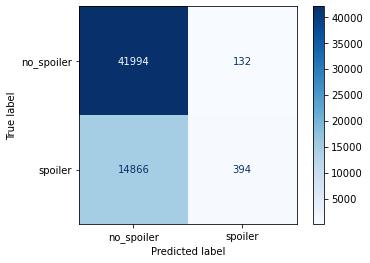

In [11]:
# instantiate multinomial naive bayes model
mnb_v1 = MultinomialNB()
# fit, predict and report with helper function
fitpredreport(mnb_v1)

Definitely not better than our baseline.
_________
Logistic Regression

[LibLinear]              precision    recall  f1-score   support

  no_spoiler       0.80      0.92      0.86     42126
     spoiler       0.63      0.36      0.46     15260

    accuracy                           0.78     57386
   macro avg       0.72      0.64      0.66     57386
weighted avg       0.76      0.78      0.75     57386



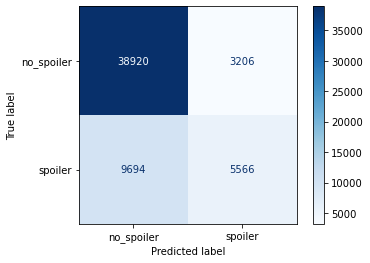

In [12]:
# instantiate logistic regression model
lr_v1 = LogisticRegression(verbose=1, solver='liblinear', random_state=42, C=5, max_iter=1000)
# fit, predict and report with helper function
fitpredreport(lr_v1)

________
SVM

              precision    recall  f1-score   support

  no_spoiler       0.80      0.93      0.86     42126
     spoiler       0.63      0.35      0.45     15260

    accuracy                           0.77     57386
   macro avg       0.72      0.64      0.66     57386
weighted avg       0.75      0.77      0.75     57386



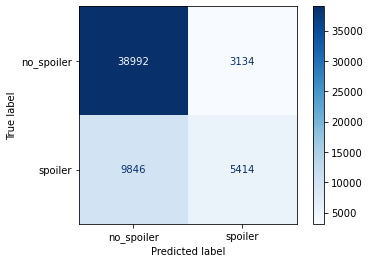

In [13]:
# instantiate SVM model
svm_v1 = LinearSVC(random_state=42)
# fit, predict and report with helper function
fitpredreport(svm_v1)

____________
RandomForest

              precision    recall  f1-score   support

  no_spoiler       0.74      1.00      0.85     42126
     spoiler       0.76      0.02      0.05     15260

    accuracy                           0.74     57386
   macro avg       0.75      0.51      0.45     57386
weighted avg       0.74      0.74      0.64     57386



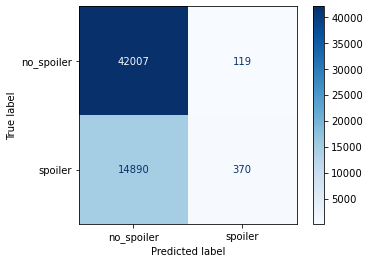

In [28]:
# this cell is using the pruned df with non-english reviews removed
# instantiate random forest classifier
rf_v1 = RandomForestClassifier(random_state=42, n_jobs=-1)
# fit, predict and report with helper function
fitpredreport(rf_v1)

____________
XGBoost

In [14]:
xgb_v1 = XGBClassifier(random_state=42, n_jobs=-1)
fitpredreport(xgb_v1)

MemoryError: Unable to allocate 787. GiB for an array with shape (230160, 459088) and data type float64

## tfidf, min occurance 8

Transforming the training/validation sets takes about a minute and generates a 230,844 word vocabulary

In [9]:
# set tfidf vectorizer, default parameters
tfidf_eight = TfidfVectorizer(min_df=8)

X_train_tfidf, X_val_tfidf = transformX(tfidf_eight)

# helper function to make fitting, predicting and reporting easier
def fitpredreport(model):
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_val_tfidf)
    report(y_val, y_pred)

________
Multinomial Naive Bayes

              precision    recall  f1-score   support

  no_spoiler       0.75      0.98      0.85     42126
     spoiler       0.67      0.12      0.20     15260

    accuracy                           0.75     57386
   macro avg       0.71      0.55      0.52     57386
weighted avg       0.73      0.75      0.68     57386



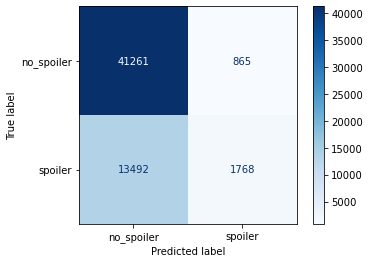

In [10]:
# instantiate multinomial naive bayes model
mnb_v2 = MultinomialNB()
# fit, predict and report with helper function
fitpredreport(mnb_v2)

Definitely not better than our baseline.
_________
Logistic Regression

[LibLinear]              precision    recall  f1-score   support

  no_spoiler       0.80      0.92      0.86     42126
     spoiler       0.64      0.36      0.46     15260

    accuracy                           0.78     57386
   macro avg       0.72      0.64      0.66     57386
weighted avg       0.76      0.78      0.75     57386



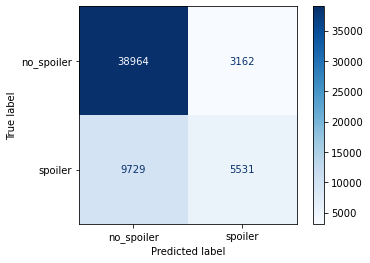

In [11]:
# instantiate logistic regression model
lr_v2 = LogisticRegression(verbose=1, solver='liblinear', random_state=42, C=5, max_iter=1000)
# fit, predict and report with helper function
fitpredreport(lr_v2)

________
SVM

              precision    recall  f1-score   support

  no_spoiler       0.80      0.93      0.86     42126
     spoiler       0.64      0.35      0.45     15260

    accuracy                           0.77     57386
   macro avg       0.72      0.64      0.66     57386
weighted avg       0.76      0.77      0.75     57386



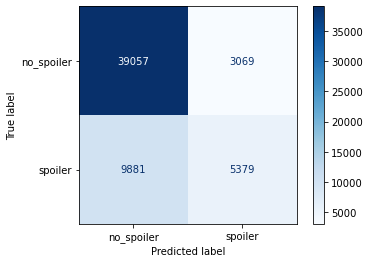

In [12]:
# instantiate SVM model
svm_v2 = LinearSVC(random_state=42)
# fit, predict and report with helper function
fitpredreport(svm_v2)

____________
RandomForest

              precision    recall  f1-score   support

  no_spoiler       0.74      1.00      0.85     42126
     spoiler       0.78      0.05      0.09     15260

    accuracy                           0.74     57386
   macro avg       0.76      0.52      0.47     57386
weighted avg       0.75      0.74      0.65     57386



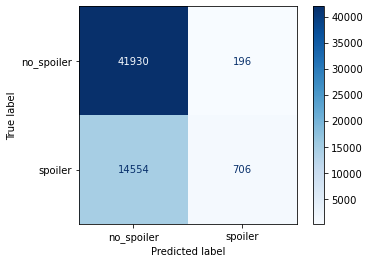

In [13]:
# this cell is using the pruned df with non-english reviews removed
# instantiate random forest classifier
rf_v1 = RandomForestClassifier(random_state=42, n_jobs=-1)
# fit, predict and report with helper function
fitpredreport(rf_v1)

____________
XGBoost

In [14]:
xgb_v1 = XGBClassifier(random_state=42, n_jobs=-1)
fitpredreport(xgb_v1)

MemoryError: Unable to allocate 182. GiB for an array with shape (53207, 459088) and data type float64

## tfidf with bigrams, min occurance 5

In [10]:
# set tfidf vectorizer, default parameters
tfidf_bigrams = TfidfVectorizer(min_df=5, ngram_range=(1,2))

X_train_tfidf, X_val_tfidf = transformX(tfidf_bigrams)

# helper function to make fitting, predicting and reporting easier
def fitpredreport(model):
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_val_tfidf)
    report(y_val, y_pred)

Transforming the training/validation sets takes about 4 minutes and generates a 1,576,114 word vocabulary

________
Multinomial Naive Bayes

              precision    recall  f1-score   support

  no_spoiler       0.74      1.00      0.85     42206
     spoiler       0.80      0.01      0.01     15185

    accuracy                           0.74     57391
   macro avg       0.77      0.50      0.43     57391
weighted avg       0.75      0.74      0.63     57391



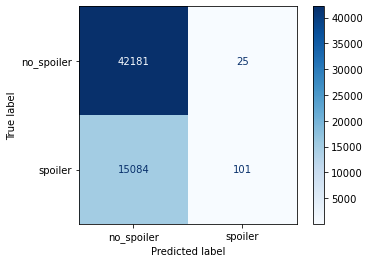

In [8]:
# instantiate multinomial naive bayes model
mnb_v2 = MultinomialNB()
# fit, predict and report with helper function
fitpredreport(mnb_v2)

Definitely not better than our baseline.
_________
Logistic Regression

[LibLinear]              precision    recall  f1-score   support

  no_spoiler       0.81      0.92      0.86     42206
     spoiler       0.64      0.38      0.48     15185

    accuracy                           0.78     57391
   macro avg       0.72      0.65      0.67     57391
weighted avg       0.76      0.78      0.76     57391



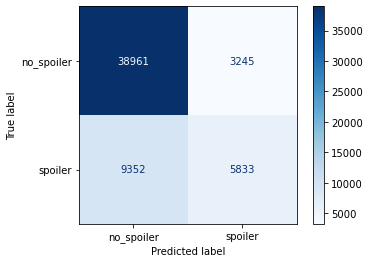

In [9]:
# instantiate logistic regression model
lr_v2 = LogisticRegression(verbose=1, solver='liblinear', random_state=42, C=5, max_iter=1000)
# fit, predict and report with helper function
fitpredreport(lr_v2)

Better than the base tfidf, but still not better than baseline.
_________
SVM

              precision    recall  f1-score   support

  no_spoiler       0.81      0.91      0.86     42206
     spoiler       0.61      0.40      0.48     15185

    accuracy                           0.77     57391
   macro avg       0.71      0.65      0.67     57391
weighted avg       0.76      0.77      0.76     57391



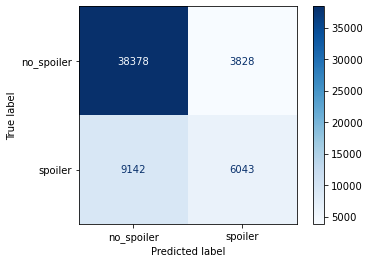

In [8]:
# instantiate SVM model
svm_v2 = LinearSVC(random_state=42)
# fit, predict and report with helper function
fitpredreport(svm_v2)

____________
RandomForest

              precision    recall  f1-score   support

  no_spoiler       0.74      1.00      0.85     42206
     spoiler       0.73      0.01      0.01     15185

    accuracy                           0.74     57391
   macro avg       0.74      0.50      0.43     57391
weighted avg       0.74      0.74      0.63     57391



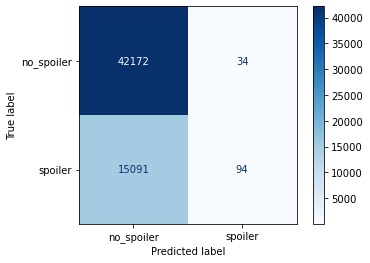

In [11]:
# instantiate random forest classifier
rf_v2 = RandomForestClassifier(random_state=42, n_jobs=-1)
# fit, predict and report with helper function
fitpredreport(rf_v2)

## tfidf with bi- and tri-grams, min occurance 5

We saw some improvement over just unigrams, we're going to try adding in trigrams as well to see if that improves further. We suspect we may be at the limit of improvement using bag of words.

In [7]:
# set tfidf vectorizer
tfidf_trigrams = TfidfVectorizer(min_df=5, ngram_range=(1,3))

X_train_tfidf, X_val_tfidf = transformX(tfidf_trigrams)

# helper function to make fitting, predicting and reporting easier
def fitpredreport(model):
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_val_tfidf)
    report(y_val, y_pred)

Transforming the training/validation sets takes about 16 minutes and generates a 2,392,535 word vocabulary
_________
Naive Bayes models have not been performing well, so we're just going to start with logistic regression

[LibLinear]              precision    recall  f1-score   support

  no_spoiler       0.81      0.93      0.86     42206
     spoiler       0.65      0.38      0.48     15185

    accuracy                           0.78     57391
   macro avg       0.73      0.65      0.67     57391
weighted avg       0.76      0.78      0.76     57391



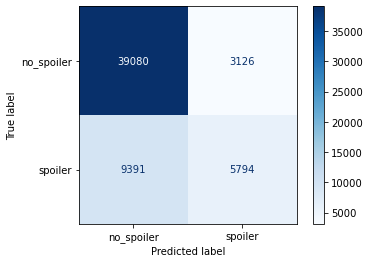

In [11]:
# instantiate logistic regression model
lr_v3 = LogisticRegression(verbose=1, solver='liblinear', random_state=42, C=5, max_iter=1000)
# fit, predict and report with helper function
fitpredreport(lr_v3)

.
_________
SVM

              precision    recall  f1-score   support

  no_spoiler       0.81      0.91      0.86     42206
     spoiler       0.62      0.40      0.49     15185

    accuracy                           0.78     57391
   macro avg       0.71      0.66      0.67     57391
weighted avg       0.76      0.78      0.76     57391



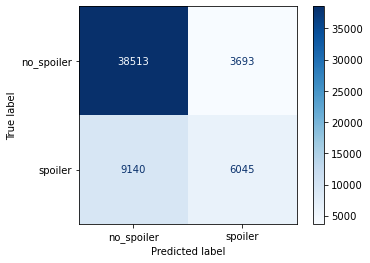

In [8]:
# instantiate SVM model
svm_v3 = LinearSVC(random_state=42)
# fit, predict and report with helper function
fitpredreport(svm_v3)

As we expanded the vocabulary with ngrams, we did see improvement in recall on spoilers, but our FP rate is still above 50%. We will explore another angle.

# Word2Vec

# roBERTa

In [39]:
# import fastai, torch, pytorch_transformers
from fastai.text.all import *
from fastai.metrics import *
import torch
import torch.nn as nn
from pytorch_transformers import RobertaTokenizer
from pytorch_transformers import RobertaModel
# Garbage Collector
import gc 

In [30]:
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
            
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)
        
"""
seed: diff seed can have diff train and validate dataset (how to split)
roberta_model_name: roberta-large/roberta-base
max_lr: maximum learning rate
epochs: number of epochs
bs: batch size, set 4 because of limitation of GPU memory
max_seq_len: the maximum nlength of tokens in a sentence
num_labels: number of categories
hidden_dropout_prob: the percentage of dropout
hidden_size: 1024 for roberta-large and 768 for roberta-base
valida_pct: percentage of validation dataset
start_tok: start of sentence
end_tok: end of a sentence
model_path: path of model
pred_path: path of prediction
train_file_path: path of training dataset
test_file_path: path of test dataset
text_column_name: column name of text
target_column_name: column name of target/label
"""
        
config = Config(
    file_path="./data/",
    date = pendulum.now().strftime('%Y%m%d'),
    seed=18,
    roberta_model_name='roberta-base',
    max_lr=1e-5,
    epochs=1,
    bs=4,
    max_seq_len=200,
    num_labels=2,
    hidden_dropout_prob=0.4,
    hidden_size=768,
    valid_pct=0.10,
    start_tok="<./s>",
    end_tok="<./s>",
#     model_path='Model_Roberta.pkl',
#     pred_path='Prediction_Roberta.csv',
#     train_file_path='train.csv',
#     test_file_path='test.csv',
    text_column_name='review_text_lemmed',
    target_column_name='is_spoiler'
)

In [32]:
config.model_path = f'{config.file_path}/models/{config.roberta_model_name}_Epoch_{config.epochs}_len_{config.max_seq_len}_{config.date}.pkl'
config.pred_path = f'{config.file_path}/pred/{config.roberta_model_name}_Epoch_{config.epochs}_len_{config.max_seq_len}_{config.date}.csv'
config.train_file_path=f'{config.file_path}/train.csv'
config.test_file_path=f'{config.file_path}/test.csv'

In [ ]:
Tokenizer()

In [42]:
class FastAiRobertaTokenizer(BaseTokenizer):
    """Wrapper around RobertaTokenizer to be compatible with fastai"""
    def __init__(self, tokenizer: RobertaTokenizer, max_seq_len: int=128, **kwargs): 
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len 
    def __call__(self, *args, **kwargs): 
        return self 
    def tokenizer(self, t:str) -> list[str]: 
        """Adds Roberta bos and eos tokens and limits the maximum sequence length""" 
        return [config.start_tok] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + [config.end_tok]

# create fastai tokenizer for roberta
roberta_tok = RobertaTokenizer.from_pretrained(config.roberta_model_name)

fastai_tokenizer = Tokenizer(tok=FastAiRobertaTokenizer(roberta_tok, max_seq_len=config.max_seq_len))

# create fastai vocabulary for roberta
path = Path()
roberta_tok.save_vocabulary(path)

with open('vocab.json', 'r') as f:
    roberta_vocab_dict = json.load(f)
    
fastai_roberta_vocab = Vocab(list(roberta_vocab_dict.keys()))

# Setting up pre-processors
class RobertaTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
         super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)

class RobertaNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=fastai_roberta_vocab, **kwargs)


def get_roberta_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    """
    Constructing preprocessors for Roberta
    We remove sos and eos tokens since we add that ourselves in the tokenizer.
    We also use a custom vocabulary to match the numericalization with the original Roberta model.
    """
    return [RobertaTokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(vocab=vocab)]

UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 71438: character maps to <undefined>

In [ ]:
# Creating a Roberta specific DataBunch class
class RobertaDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training Roberta"
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=64, val_bs:int=None, pad_idx=1,
               pad_first=True, device:torch.device=None, no_check:bool=False, backwards:bool=False, 
               dl_tfms:Optional[Collection[Callable]]=None, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(pad_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, dl_tfms=dl_tfms, collate_fn=collate_fn, no_check=no_check)

class RobertaTextList(TextList):
    _bunch = RobertaDataBunch
    _label_cls = TextList

# load dataset
train_df = pd.read_csv(config.train_file_path)
test_df = pd.read_csv(config.test_file_path)
feat_cols = config.text_column_name
label_cols = config.target_column_name

# loading the tokenizer and vocab processors
processor = get_roberta_processor(
    tokenizer=fastai_tokenizer, vocab=fastai_roberta_vocab)

'''
creating databunch
from_df: import the data
split_by_rand_pct: split the data between the training and the validation set
label_from_df: get label from dataset
add_test: get test dataset
databunch: get some config (batch size)
'''
data = RobertaTextList.from_df(train_df, ".", cols=feat_cols, processor=processor) \
    .split_by_rand_pct(valid_pct=config.valid_pct, seed=config.seed) \
    .label_from_df(cols=label_cols, label_cls=CategoryList) \
    .add_test(RobertaTextList.from_df(test_df, ".", cols=feat_cols, processor=processor)) \
    .databunch(bs=config.bs, pad_first=False, pad_idx=0)

# remove unnecessary files
del train_df  
del test_df 
gc.collect()  # clean the memory